# MoViNet Tutorial

This notebook provides basic example code to build, run, and fine-tune [MoViNets (Mobile Video Networks)](https://arxiv.org/pdf/2103.11511.pdf).

Pretrained models are provided by [TensorFlow Hub](https://tfhub.dev/google/collections/movinet/) and the [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official/projects/movinet), trained on [Kinetics 600](https://deepmind.com/research/open-source/kinetics) for video action classification. All Models use TensorFlow 2 with Keras for inference and training.

The following steps will be performed:

1. [Running base model inference with TensorFlow Hub](#scrollTo=6g0tuFvf71S9&line=8&uniqifier=1)
2. [Running streaming model inference with TensorFlow Hub and plotting predictions](#scrollTo=ADrHPmwGcBZ5&line=4&uniqifier=1)
3. [Exporting a streaming model to TensorFlow Lite for mobile](#scrollTo=W3CLHvubvdSI&line=3&uniqifier=1)
4. [Fine-Tuning a base Model with the TensorFlow Model Garden](#scrollTo=_s-7bEoa3f8g&line=11&uniqifier=1)

![jumping jacks plot](https://storage.googleapis.com/tf_model_garden/vision/movinet/artifacts/jumpingjacks_plot.gif)

To generate video plots like the one above, see [section 2](#scrollTo=ADrHPmwGcBZ5&line=4&uniqifier=1).

## Setup

For inference on smaller models (A0-A2), CPU is sufficient for this Colab. For fine-tuning, it is recommended to run the models using GPUs.

To select a GPU in Colab, select `Runtime > Change runtime type > Hardware accelerator > GPU` dropdown in the top menu.

In [1]:
# Install packages

# tf-models-official is the stable Model Garden package
# tf-models-nightly includes latest changes
!pip install -q tf-models-nightly

# Install tfds nightly to download ucf101
!pip install -q tfds-nightly

# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

# Due to a bug, we reinstall opencv
# See https://stackoverflow.com/q/70537488
!pip uninstall -q -y opencv-python-headless
!pip install -q "opencv-python-headless<4.3"

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



In [1]:
# Run imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tqdm

mpl.rcParams.update({
    'font.size': 10,
})

ModuleNotFoundError: No module named 'mediapy'

In [4]:
! pip install tensorflow==2.8
! apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.8
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



Run the cell below to define helper functions and create variables.

In [4]:
#@title Run this cell to set up some helper code.

# Download Kinetics 600 label map
!wget https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt -O labels.txt -q

with tf.io.gfile.GFile('labels.txt') as f:
  lines = f.readlines()
  KINETICS_600_LABELS_LIST = [line.strip() for line in lines]
  KINETICS_600_LABELS = tf.constant(KINETICS_600_LABELS_LIST)

def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

def load_movinet_from_hub(model_id, model_mode, hub_version=3):
  """Loads a MoViNet model from TF Hub."""
  hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/{model_mode}/kinetics-600/classification/{hub_version}'

  encoder = hub.KerasLayer(hub_url, trainable=True)

  inputs = tf.keras.layers.Input(
      shape=[None, None, None, 3],
      dtype=tf.float32)

  if model_mode == 'base':
    inputs = dict(image=inputs)
  else:
    # Define the state inputs, which is a dict that maps state names to tensors.
    init_states_fn = encoder.resolved_object.signatures['init_states']
    state_shapes = {
        name: ([s if s > 0 else None for s in state.shape], state.dtype)
        for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
    }
    states_input = {
        name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
        for name, (shape, dtype) in state_shapes.items()
    }

    # The inputs to the model are the states and the video
    inputs = {**states_input, 'image': inputs}

  # Output shape: [batch_size, 600]
  outputs = encoder(inputs)

  model = tf.keras.Model(inputs, outputs)
  model.build([1, 1, 1, 1, 3])

  return model

# Download example gif
!wget https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif -O jumpingjack.gif -q

def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS_LIST):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]

  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames

  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])

  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')

  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image, (fig, ax, ax2)

def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  video_fps = 8.
  figure_height = 500
  steps = video.shape[0]
  duration = steps / video_fps

  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image, _ = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

## Running Base Model Inference with TensorFlow Hub

We will load MoViNet-A2-Base from TensorFlow Hub as part of the [MoViNet collection](https://tfhub.dev/google/collections/movinet/).

The following code will:

- Load a MoViNet KerasLayer from [tfhub.dev](https://tfhub.dev).
- Wrap the layer in a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
- Load an example gif as a video.
- Classify the video and print the top-5 predicted classes.

In [4]:
model = load_movinet_from_hub('a2', 'base', hub_version=3)

To provide a simple example video for classification, we can load a short gif of jumping jacks being performed.

![jumping jacks](https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif)

Attribution: Footage shared by [Coach Bobby Bluford](https://www.youtube.com/watch?v=-AxHpj-EuPg) on YouTube under the CC-BY license.

In [5]:
video = load_gif('jumpingjack.gif', image_size=(172, 172))

# Show video
print(video.shape)
media.show_video(video.numpy(), fps=5)

(13, 172, 172, 3)


In [6]:
video.numpy().shape #13 frames with h=172,w=172 and 3 color channels (RGB)

(13, 172, 172, 3)

In [7]:
# Run the model on the video and output the top 5 predictions
outputs = predict_top_k(model, video)

for label, prob in outputs:
  print(label, prob)

UnknownError: ignored

## Run Streaming Model Inference with TensorFlow Hub and Plot Predictions

We will load MoViNet-A0-Stream from TensorFlow Hub as part of the [MoViNet collection](https://tfhub.dev/google/collections/movinet/).

The following code will:

- Load a MoViNet model from [tfhub.dev](https://tfhub.dev).
- Classify an example video and plot the streaming predictions over time.

In [ ]:
model = load_movinet_from_hub('a2', 'stream', hub_version=3)

# Create initial states for the stream model
init_states_fn = model.layers[-1].resolved_object.signatures['init_states']
init_states = init_states_fn(tf.shape(video[tf.newaxis]))

In [ ]:
# Insert your video clip here
video = load_gif('jumpingjack.gif', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for clip in tqdm.tqdm(clips):
  # Input shape: [1, 1, 172, 172, 3]
  logits, states = model.predict({**states, 'image': clip}, verbose=0)
  all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
for label, prob in top_k:
  print(label, prob)

100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
jumping jacks 0.9998123
zumba 0.00011835508
doing aerobics 3.3375818e-05
dancing charleston 4.9819987e-06
finger snapping 3.8673647e-06


In [ ]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

In [ ]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=3)

## Export a Streaming Model to TensorFlow Lite for Mobile

We will convert a MoViNet-A0-Stream model to [TensorFlow Lite](https://www.tensorflow.org/lite).

The following code will:
- Load a MoViNet-A0-Stream model.
- Convert the model to TF Lite.
- Run inference on an example video using the Python interpreter.

In [ ]:
# Run imports
from official.vision.configs import video_classification
from official.projects.movinet.configs import movinet as movinet_configs
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_layers
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

In [ ]:
# Export to saved model
saved_model_dir = 'model'
tflite_filename = 'model.tflite'
input_shape = [1, 1, 172, 172, 3]
batch_size, num_frames, image_size, = input_shape[:3]

tf.keras.backend.clear_session()

# Create the model
input_specs = tf.keras.layers.InputSpec(shape=input_shape)
backbone = movinet.Movinet(
    model_id='a0',
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    input_specs=input_specs,
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_sync_bn=False,
    use_external_states=True)
model = movinet_model.MovinetClassifier(
    backbone=backbone,
    activation='hard_swish',
    num_classes=600,
    output_states=True,
    input_specs=dict(image=input_specs))
model.build([1, 1, 1, 1, 3])

# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False,
    checkpoint_path=checkpoint_path)

In [ ]:
# Convert to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
runner = interpreter.get_signature_runner()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']

In [ ]:
# Insert your video clip here
video = load_gif('jumpingjack.gif', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

# To run on a video, pass in one frame at a time
states = init_states
for clip in clips:
  # Input shape: [1, 1, 172, 172, 3]
  outputs = runner(**states, image=clip)
  logits = outputs.pop('logits')[0]
  states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)

jumping jacks 0.9791285
jogging 0.0019550633
riding unicycle 0.0017429002
passing soccer ball 0.0016952101
stretching arm 0.0014458151


## Fine-Tune a Base Model with the TensorFlow Model Garden

We will Fine-tune MoViNet-A0-Base on [UCF-101](https://www.crcv.ucf.edu/research/data-sets/ucf101/).

The following code will:

- Load the UCF-101 dataset with [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/ucf101).
- Create a simple [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline for training and evaluation.
- Display some example videos from the dataset.
- Build a MoViNet model and load pretrained weights.
- Fine-tune the final classifier layers on UCF-101 and evaluate accuracy on the validation set.

### Load the UCF-101 Dataset with TensorFlow Datasets

Calling `download_and_prepare()` will automatically download the dataset. This step may take up to 1 hour depending on the download and extraction speed. After downloading, the next cell will output information about the dataset.

In [5]:
# Run imports
import tensorflow_datasets as tfds

from official.vision.configs import video_classification
from official.projects.movinet.configs import movinet as movinet_configs
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_layers
from official.projects.movinet.modeling import movinet_model

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220724). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [ ]:
dataset_name = 'ucf101'

builder = tfds.builder(dataset_name)

config = tfds.download.DownloadConfig(verify_ssl=False)
builder.download_and_prepare(download_config=config)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9537 [00:00<?, ? examples/s]

In [10]:
num_classes = builder.info.features['label'].num_classes
num_examples = { name: split.num_examples for name, split in builder.info.splits.items()}

print('Number of classes:', num_classes)
print('Number of examples for train:', num_examples['train'])
print('Number of examples for test:', num_examples['test'])
print()

builder.info

Number of classes: 101
Number of examples for train: 9537
Number of examples for test: 3783



tfds.core.DatasetInfo(
    name='ucf101',
    full_name='ucf101/2.0.0',
    description="""
    A 101-label video classification dataset.
    """,
    config_description="""
    256x256 UCF with the first action recognition split.
    """,
    homepage='https://www.crcv.ucf.edu/data-sets/ucf101/',
    data_path='/tmp/tmpuma4j2gftfds',
    file_format=tfrecord,
    download_size=6.48 GiB,
    dataset_size=7.41 GiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
        'video': Video(Image(shape=(256, 256, 3), dtype=tf.uint8)),
    }),
    supervised_keys=None,
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=3783, num_shards=32>,
        'train': <SplitInfo num_examples=9537, num_shards=64>,
    },
    citation="""@article{DBLP:journals/corr/abs-1212-0402,
      author    = {Khurram Soomro and
                   Amir Roshan Zamir and
                   Mubarak Shah},
      title     = {{UCF101:} {A} D

In [11]:
num_classes

101

In [12]:
# Build the training and evaluation datasets.

batch_size = 8 #8 videos per batch
num_frames = 8
frame_stride = 10
resolution = 172

def format_features(features):
  video = features['video']
  video = video[:, ::frame_stride]
  video = video[:, :num_frames]

  video = tf.reshape(video, [-1, video.shape[2], video.shape[3], 3])
  video = tf.image.resize(video, (resolution, resolution))
  video = tf.reshape(video, [-1, num_frames, resolution, resolution, 3])
  video = tf.cast(video, tf.float32) / 255.

  label = tf.one_hot(features['label'], num_classes)
  return (video, label)

train_dataset = builder.as_dataset(
                                    split='train',
                                    batch_size=batch_size,
                                    shuffle_files=True)
train_dataset = train_dataset.map(
                                    format_features,
                                    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(2)

test_dataset = builder.as_dataset(
                                    split='test',
                                    batch_size=batch_size)
test_dataset = test_dataset.map(
                                    format_features,
                                    num_parallel_calls=tf.data.AUTOTUNE,
                                    deterministic=True)
test_dataset = test_dataset.prefetch(2)

In [13]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8, 172, 172, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [14]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8, 172, 172, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

Display some example videos from the dataset.

,,,,,,,

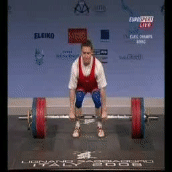
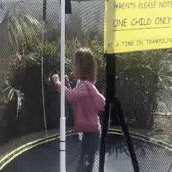
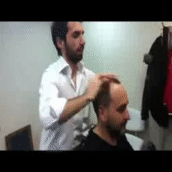
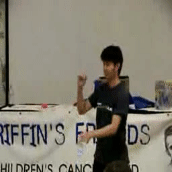
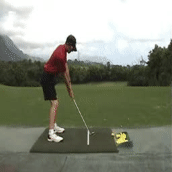
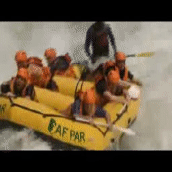
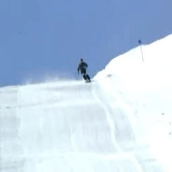
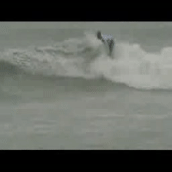

In [15]:
videos, labels = next(iter(train_dataset))
media.show_videos(videos.numpy(), codec='gif', fps=5)

In [17]:
videos.shape

TensorShape([8, 8, 172, 172, 3])

In [18]:
videos[0].shape

TensorShape([8, 172, 172, 3])

In [20]:
labels.shape #[8, 101] #8 videos (1 row per video), 101 label categories (101 columns)
            # our label tensor would have same (364, 2) = 364 rows of one-hot vectors [0, 1] or [1, 0] 
            # where the first position == 1 denotes relevant label and the second position == 1 denotes irrelevant label

TensorShape([8, 101])

In [21]:
labels

<tf.Tensor: shape=(8, 101), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 

### Build MoViNet-A0-Base and Load Pretrained Weights

Here we create a MoViNet model using the open source code provided in [official/projects/movinet](https://github.com/tensorflow/models/tree/master/official/projects/movinet) and load the pretrained weights. Here we freeze the all layers except the final classifier head to speed up fine-tuning.

In [22]:
model_id = 'a0'

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([1, 1, 1, 1, 3])

# Load pretrained weights (this is what we load in later on as `checkpoint_dir`)
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = 'movinet_a0_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

def build_classifier(backbone, num_classes, freeze_backbone=False):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
                                          backbone=backbone,
                                          num_classes=num_classes
                                         )
  model.build([batch_size, num_frames, resolution, resolution, 3])

  if freeze_backbone:
    for layer in model.layers[:-1]:
      layer.trainable = False
    model.layers[-1].trainable = True

  return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, num_classes, freeze_backbone=True)

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


Configure fine-tuning with training/evaluation steps, loss object, metrics, learning rate, optimizer, and callbacks.

Here we use 3 epochs. Training for more epochs should improve accuracy.

In [23]:
#set training/eval steps
num_epochs = 3

train_steps = num_examples['train'] // batch_size
total_train_steps = train_steps * num_epochs
test_steps = num_examples['test'] // batch_size

#set loss object
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

#set metrics
metrics = [
    tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1', dtype=tf.float32),
    tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5', dtype=tf.float32),
]

#set learning rate
initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)

#set optimizer
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

#compile model
model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

#set callbacks (Tensorboard)
callbacks = [
    tf.keras.callbacks.TensorBoard(),
]

Run the fine-tuning with Keras compile/fit. After fine-tuning the model, we should be able to achieve >85% accuracy on the test set.

In [24]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8, 172, 172, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [26]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 462 kB 31.8 MB/s 
  Attempting uninstall: tf-estimator-nightly
    Found existing installation: tf-estimator-nightly 2.10.0.dev2022072408
    Uninstalling tf-estimator-nightly-2.10.0.dev2022072408:
      Successfully uninstalled tf-estimator-nightly-2.10.0.dev2022072408
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.10.0.dev20220724 requires tf-estimator-nightly~=2.10.0.dev, but you have tf-estimator-nightly 2.8.0.dev2021

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (56.2 MB/s)
(Reading database ... 155653 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155631 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

In [1]:
results = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks,
    validation_freq=1,
    verbose=1)

NameError: ignored

We can also view the training and evaluation progress in TensorBoard.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 0